# Load Packages

In [1]:
import sys
sys.path.append('..')

In [2]:
from fracdiff import fracdiff
import numpy as np
import scipy.special

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#!pip install memory_profiler
import line_profiler
%load_ext line_profiler

In [5]:
#!pip install memory_profiler
import memory_profiler
%load_ext memory_profiler

# Load Demo Data

In [6]:
with np.load('data/demo1.npz') as data:
    t = data['t']
    px = data['px']

In [7]:
x = px[:, 0]

In [8]:
del t, px

# Modeling

## (a) First Order Differentiation
Let $x_t$ a time series, 
$t\in\mathbb{N}$ the time step,
$\Delta^1$ the difference operator for first order $d=1$

$$
(\Delta^1 x)_t = x_t - x_{t-1}
$$


Example

In [9]:
z = x[1:] - x[:-1]
z

array([-2.2 ,  0.91, -1.93, ..., -1.56,  0.67,  0.  ])

Wrap it into a function

In [10]:
def firstdiff(x: np.ndarray) -> np.ndarray:
    z = np.empty(shape=x.shape)
    z[0] = np.nan
    z[1:] = x[1:] - x[:-1]
    return z

In [11]:
%time z = firstdiff(x)
print(z[:10])

CPU times: user 71 µs, sys: 28 µs, total: 99 µs
Wall time: 152 µs
[  nan -2.2   0.91 -1.93 -0.3   1.17  1.87  0.74 -0.46  0.14]


## (b) Integral Differentiation
Let $x_t$ a time series, 
$t\in\mathbb{N}$ the time step,
$\Delta^d$ the difference operator of integral order $d\in\mathbb{N}^+$

$$
(\Delta^d x)_t = \sum_{k=0}^d (-1)^k {d\choose k} x_{t-k}
$$


Example with `d=1`

In [12]:
# generate weights
d = 1
w = np.empty((d+1,))
for k in range(d+1):
    w[k] = np.power(-1, k) * scipy.special.binom(d, k)

print(w)

[ 1. -1.]


In [13]:
# apply weights
z = w[0] * x
z[:d] = np.nan
for k in range(1, d+1):
    z[k:] += w[k] * x[:-k]
    
print(z[:10])

[  nan -2.2   0.91 -1.93 -0.3   1.17  1.87  0.74 -0.46  0.14]


Wrap it in a function

In [14]:
def intdiff(x: np.ndarray, d: int) -> (np.ndarray, np.ndarray):
    # generate weights
    w = np.empty((d + 1,))
    for k in range(d+1):
        w[k] = np.power(-1, k) * scipy.special.binom(d, k)
    # apply weights
    z = w[0] * x
    z[:d] = np.nan
    for k in range(1, d+1):
        z[k:] += w[k] * x[:-k]
    return z, w

In [15]:
%time z, _ = intdiff(x, 1)
print(z[:10])

CPU times: user 339 µs, sys: 201 µs, total: 540 µs
Wall time: 426 µs
[  nan -2.2   0.91 -1.93 -0.3   1.17  1.87  0.74 -0.46  0.14]


In [16]:
z, _ = intdiff(x, 2)
print(z[:10])

[  nan   nan  3.11 -2.84  1.63  1.47  0.7  -1.13 -1.2   0.6 ]


In [17]:
z, _ = intdiff(x, 3)
print(z[:10])

[  nan   nan   nan -5.95  4.47 -0.16 -0.77 -1.83 -0.07  1.8 ]


## (c) Fractional Differentiation 
Let $x_t$ a time series, 
$t\in\mathbb{N}$ the time step,
$\Delta^d$ the difference operator of fractional order $d\in\mathbb{R}^+$,
and $m$ the truncation order

$$
(\Delta^d x)_t = x_t + \sum_{k=1}^\infty \left(\prod_{i=1}^k \frac{d - i + 1}{i} \right) x_{t-k} \\
(\Delta^d x)_t \approx x_t + \sum_{k=1}^m \left(\prod_{i=1}^k \frac{d - i + 1}{i} \right) x_{t-k}
$$

(see Lopez, 2018, p.78, from the 'iterative estimation' formula; Jensen and Nielsen, 2014)

In [18]:
%time z = fracdiff(x, order=1)
print(z[:10])
#plt.plot(z);

CPU times: user 125 µs, sys: 45 µs, total: 170 µs
Wall time: 177 µs
[  nan -2.2   0.91 -1.93 -0.3   1.17  1.87  0.74 -0.46  0.14]


CPU times: user 11.7 ms, sys: 1.61 ms, total: 13.4 ms
Wall time: 57.8 ms


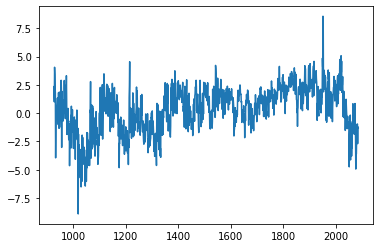

In [19]:
%time z = fracdiff(x, order=0.5)
plt.plot(z);

CPU times: user 2.45 ms, sys: 2.02 ms, total: 4.47 ms
Wall time: 2.47 ms


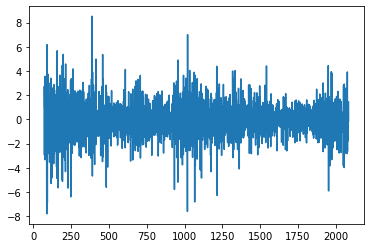

In [20]:
%time z = fracdiff(x, order=1.5)
plt.plot(z);

# Speed

In [21]:
%timeit z = firstdiff(x)
%timeit z, _ = intdiff(x, 1)
%timeit z = fracdiff(x, order=1)

6.75 µs ± 652 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
52.7 µs ± 9.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
23.6 µs ± 4.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Memory

In [22]:
%memit z = firstdiff(x)
%memit z, _ = intdiff(x, 1)
%memit z = fracdiff(x, order=1)

peak memory: 90.23 MiB, increment: -0.34 MiB
peak memory: 89.79 MiB, increment: -0.38 MiB
peak memory: 89.68 MiB, increment: -0.05 MiB


# Line-by-Line

In [23]:
%lprun -f fracdiff fracdiff(x, order=1)

Timer unit: 1e-06 s

Total time: 0.001119 s
File: ../fracdiff/fracdiff_fn.py
Function: fracdiff at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def fracdiff(X: np.ndarray, order: float = None, weights: list = None,
     8                                                        truncation: int = None, tau: float = 1e-5, mmax: int = 20000,
     9                                                        dtype=None) -> np.ndarray:
    10                                               # determine weights
    11         1        943.0    943.0     84.3      if weights is None:
    12         1          4.0      4.0      0.4          d = order if order else 0  # Default value, no differentiation
    13         1          5.0      5.0      0.4          if isinstance(truncation, int):
    14                                                       weights = frac_weights(d, truncation)
    15                                     

In [24]:
%mprun -f fracdiff fracdiff(x, order=1)

Filename: ../fracdiff/fracdiff_fn.py

Line #    Mem usage    Increment   Line Contents
     7     89.8 MiB     89.8 MiB   def fracdiff(X: np.ndarray, order: float = None, weights: list = None,
     8                                          truncation: int = None, tau: float = 1e-5, mmax: int = 20000,
     9                                          dtype=None) -> np.ndarray:
    10                                 # determine weights
    11     89.8 MiB      0.0 MiB       if weights is None:
    12     89.8 MiB      0.0 MiB           d = order if order else 0  # Default value, no differentiation
    13     89.8 MiB      0.0 MiB           if isinstance(truncation, int):
    14                                         weights = frac_weights(d, truncation)
    15                                     else:  # 'find' or None
    16     89.8 MiB      0.0 MiB               _, weights = find_truncation(d, tau=tau, mmax=mmax)
    17                             
    18                              

# References
* Jensen, A.N., Nielsen, M.Ø., 2014. A Fast Fractional Difference Algorithm. Journal of Time Series Analysis 35, 428–436. https://doi.org/10.1111/jtsa.12074
* Prado, M.L. de, 2018. Advances in Financial Machine Learning, 1st ed. Wiley.